### Plot T5Disp results using the DataFrame stored in T5DispResults.pcl 

In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import glob,imp,os
from pandas.io.json import json_normalize
import pyslha
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from collections import OrderedDict
import seaborn as sns
import itertools
from scipy.interpolate import griddata

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

In [2]:
def getSmoothCurve(x,y,z,stepX=20.,stepY=0.5,doLog=True,doMax=True,cval=1.):

    if doLog:
        yv = np.log10(y[y > 0.]).tolist()
        xv = x[y > 0.].tolist()
        zv = z[y > 0.].tolist()
    else:
        yv = y.tolist()
        xv = x.tolist()    
        zv = z.tolist()
    
    points = list(zip(xv,yv))
    xbins = np.arange(min(xv),max(xv),stepX)
    ybins = np.arange(min(yv),max(yv),stepY)
    zvals = np.array([[0.]*len(ybins)]*len(xbins))
    for ipt,pt in enumerate(points):
        if not (xbins.min() < pt[0] < xbins.max()):
            continue
        if not (ybins.min() < pt[1] < ybins.max()):
            continue
        ix = np.searchsorted(xbins,pt[0])-1
        iy = np.searchsorted(ybins,pt[1])
        if doMax:
            zvals[ix,iy] = max(zvals[ix,iy],zv[ipt])
        else:
            if zvals[ix,iy] == 0.:
                zvals[ix,iy] = zv[ipt]
            else:
                zvals[ix,iy] += zv[ipt]
                zvals[ix,iy] = zvals[ix,iy]/2.            

        
    xpoints = []
    ypoints = []
    zpoints = []
    for ix,xval in enumerate(xbins):
        for iy,yval in enumerate(ybins):
            xpoints.append(xval)
            ypoints.append(yval)
            zpoints.append(zvals[ix,iy])
    cs = plt.tricontour(xpoints,ypoints,zpoints,levels=[cval],linewidths=0)
    curve = None
    for c in cs.collections[0].get_paths():
        if curve is None:
            curve = c.vertices
        elif len(c.vertices) > len(curve):
            curve = c.vertices
    plt.cla()
    if doLog:
        curve[:,1] = np.power(10,curve[:,1])
    return curve

In [3]:
#Merge with SModelS DataFrame
dataDF = pd.read_pickle('T5DispResults.pcl')
#print(dataDF.columns.values.tolist()) #Print all columns names

In [4]:
#Set points without results with r == 0
dataDF.fillna(value={'ExptRes.result0.r' : 0.0},inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=True)
#Add simple flag for excluded points:
dataDF['excluded'] = dataDF['ExptRes.result0.r'] > 1.
#Replace zero widths by small value:
# dataDF = dataDF[dataDF['width.37'] > 0.]
dataDF['width.1000021'] = dataDF['width.1000021'].map(lambda x: x if x > 0. else 1e-50)
dataDF['ctau.1000021'] = 1.967e-16/dataDF['width.1000021']
# #Restrict ctau range:
# dataDF = dataDF[(dataDF['ctau.37'] > 0.01) & (dataDF['ctau.37'] < 1e5)]

### Get data for plotting

In [5]:
mG = dataDF['mass.1000021']
ctau = dataDF['ctau.1000021']
r = dataDF['ExptRes.result0.r']
x,y,z = mG,ctau,r

In [15]:
#Get more points for smooth plotting
pts = np.column_stack((x, np.log10(y)))
xnew = np.linspace(min(x),max(x),200)
ynew = np.linspace(np.log10(min(y)),np.log10(max(y)),200)
X,Y = np.meshgrid(xnew, ynew)
newpts = np.array(list(zip(X.flat,Y.flat)))
znew = griddata(pts,r,newpts)
znew = np.where(znew >0, znew,0.0)
Z = np.reshape(znew,(len(xnew),len(ynew)))
#Rescale y points:
Y = 10**Y
newpts[:,1] = 10**newpts[:,1]

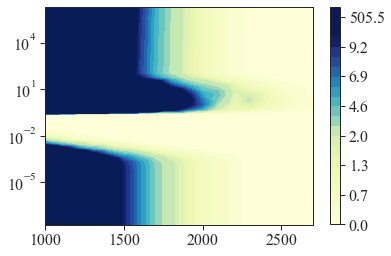

In [60]:
levels = np.sort(np.concatenate((np.linspace(0,2,10),np.linspace(3,10,10),np.linspace(11,1000,3))))

plt.contourf(X, Y, Z, levels=levels, cmap="YlGnBu",vmin=0,vmax=10)
plt.yscale('log')
plt.colorbar()
plt.show()

### Get official curves

In [17]:
excCMS = np.genfromtxt('CMS-EXO-19-001_Figure_004.csv',delimiter=',',
                       names=True) #Displaced Jets

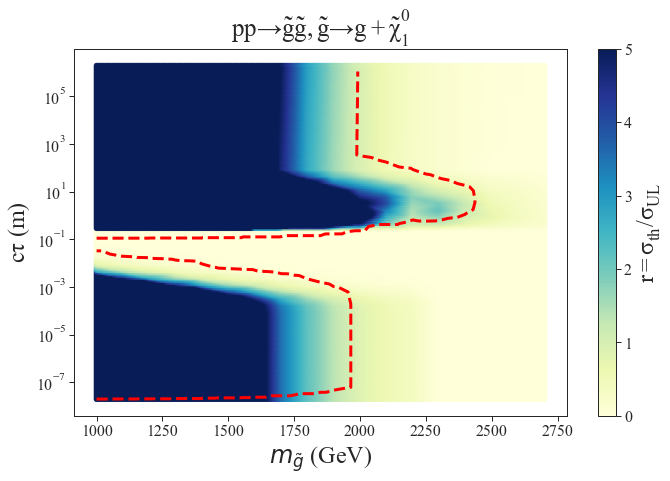

In [74]:
plt.figure(figsize=(10,7))
curve1 = getSmoothCurve(newpts[:,0],newpts[:,1],znew,stepX=50.,stepY=0.5,doLog=True,doMax=True)

curve2 = getSmoothCurve(newpts[newpts[:,1]>0.1][:,0],newpts[newpts[:,1]>0.1][:,1],znew[newpts[:,1]>0.1],
                        stepX=50.,stepY=0.5,doLog=True,doMax=True)
cp = plt.scatter(newpts[:,0],newpts[:,1], c=znew, vmin=0., vmax=5., s=25, 
                 cmap="YlGnBu")


#                  cmap=cm)
plt.plot(curve1[:,0],curve1[:,1],color='red',linewidth=3,linestyle='--')
plt.plot(curve2[:,0],curve2[:,1],color='red',linewidth=3,linestyle='--',label='SModelS')
cb = plt.colorbar(cp)
plt.yscale('log')
plt.xlabel(r'$m_{\tilde g}$ (GeV)',fontsize=24)    
plt.ylabel(r'$\mathdefault{c\tau}$ (m)',fontsize=24)
cb.set_label(r'$\mathdefault{r=\sigma_{th}/\sigma_{UL}}$',fontsize=24)
# plt.ylim(y.min(),y.max())
# plt.yticks(np.power(10.,np.arange(-2., 6., 1.)))
# plt.xlim(100,650)
# plt.xticks(np.arange(100.,700.,100.))
plt.title(r'$\mathdefault{p p \to \tilde g \tilde g, \tilde g \to g + \tilde \chi_1^0}$',fontsize=25)
plt.tight_layout()
# plt.savefig('T2Disp_points_r.png',dpi=500)
plt.show()